In [3]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.1 MB/s eta 0:00:00


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import kagglehub
from kagglehub import KaggleDatasetAdapter
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import keras_tuner as kt


In [8]:
# Descarga el dataset y convierte la ruta a tipo Path
dataset_path = Path(kagglehub.dataset_download("adityakadiwal/water-potability"))

# Usamos operador / entre objetos Path para formar la ruta completa
csv_file_path = dataset_path / "water_potability.csv"

# Leemos el archivo con pandas
df = pd.read_csv(csv_file_path)

# Mostramos las primeras filas
df.head(5)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [9]:
for col in ['ph','Sulfate','Trihalomethanes']:
  df[col].fillna(df[col].mean(),inplace=True)

df.isnull().sum()

<ipython-input-9-ff102022af7b>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(),inplace=True)


,0
ph,0
Hardness,0
Solids,0
Chloramines,0
Sulfate,0
Conductivity,0
Organic_carbon,0
Trihalomethanes,0
Turbidity,0
Potability,0


# SEPARACIÓN DATASET Y ESCALAMIENTO

In [13]:
X = df.drop(columns=["Potability"])
y = df["Potability"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# CONSTRUIMOS UN MODELO DE HIPERPARAMETROS AJUSTABLES

In [14]:
def build_model(hp):
  model = keras.Sequential()
  model.add(keras.layers.Dense(hp.Int("units1", min_value=8, max_value=64, step=8), activation="relu", input_shape=(X_train_scaled.shape[1],)))
  model.add(keras.layers.Dense(hp.Int("units2",min_value=8,max_value=64,step=8),activation='relu'))
  model.add(keras.layers.Dense(1,activation='sigmoid'))

  model.compile(
      optimizer=keras.optimizers.Adam(hp.Choice("learning_rate",[0.001,0.01,0.1])),
      loss='binary_crossentropy',
      metrics=['accuracy']
  )
  return model

# CREAMOS OBJETO DE KERAS TUNER

In [17]:
tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=20,
    factor=3,
    directory="kt_search",
    project_name='water_potability'
)

tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

Trial 30 Complete [00h 00m 10s]
val_accuracy: 0.6417682766914368

Best val_accuracy So Far: 0.6951219439506531
Total elapsed time: 00h 02m 37s


# MOSTRAMOS LOS MEJORES HIPERPARAMETROS

In [18]:
# Obtener el mejor modelo
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Mejor configuración: {best_hps.values}")

Mejor configuración: {'units1': 8, 'units2': 56, 'learning_rate': 0.01, 'tuner/epochs': 7, 'tuner/initial_epoch': 3, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0010'}


# CREAMOS UN MODELO CON LOS MEJORES HIPERPARAMETROS

In [19]:
# Entrenar el mejor modelo encontrado
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(X_train_scaled, y_train, epochs=9, validation_data=(X_test_scaled, y_test))

Epoch 1/9
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5872 - loss: 0.6907 - val_accuracy: 0.6113 - val_loss: 0.6772
Epoch 2/9
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6065 - loss: 0.6614 - val_accuracy: 0.6357 - val_loss: 0.6613
Epoch 3/9
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6661 - loss: 0.6273 - val_accuracy: 0.6357 - val_loss: 0.6382
Epoch 4/9
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6787 - loss: 0.6049 - val_accuracy: 0.6204 - val_loss: 0.6458
Epoch 5/9
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6814 - loss: 0.5905 - val_accuracy: 0.6692 - val_loss: 0.6328
Epoch 6/9
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7070 - loss: 0.5737 - val_accuracy: 0.6463 - val_loss: 0.6326
Epoch 7/9
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6784 - loss: 0.5856 - val_accuracy: 0.6616 - val_loss: 0.6302
Epoch 8/9
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6672 - loss: 0.5988 - val_accuracy: 0.6753 - val_loss: 0.6222


In [20]:
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_test)
y_pred = np.round(y_pred)

score = accuracy_score(y_test,y_pred)
print(f'el accuracy es {score}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
el accuracy es 0.6097560975609756


<Figure size 1100x1100 with 0 Axes>

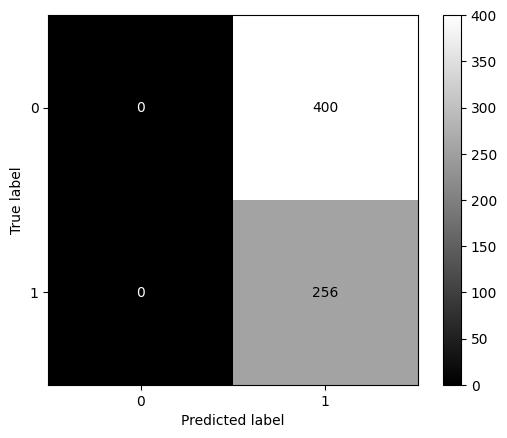

In [ ]:
matrix = confusion_matrix(y_test,y_pred)
fig = plt.figure(figsize=(11,11))
cm = matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='gray')
plt.show()